# Carbon Degassing

Compute how much carbon is degassed into the atmosphere.

Ensure notebook 02-Subducted-Carbon.ipynb has been run before this.

In [1]:
from multiprocessing import Pool, cpu_count
from joblib import Parallel, delayed
import numpy as np
import os, glob
os.environ["DISABLE_GPLATELY_DEV_WARNING"] = "true"
import gplately.pygplates as pygplates
import ptt
import gplately
import gplately.tools as tools
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import shapereader as shpreader
import netCDF4
import warnings
from scipy import ndimage
import glob, os
import pandas as pd
from slabdip import SlabDipper
from scipy.spatial import cKDTree
from rasterio.features import rasterize
from rasterio.transform import from_bounds
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

%matplotlib inline
# plt.style.use('ggplot')

# common variables
extent_globe = [-180, 180, -90, 90]
earth_radius = 6371.0e3
earth_surface_area = 4.0*np.pi*earth_radius**2
tessellation_threshold_radians = np.radians(0.01)

# output grid resolution - should be identical to input grid resolution!
spacingX, spacingY = 0.2, 0.2
resX, resY = int(360./0.2 + 1), int(180./0.2 + 1)
lon_grid = np.arange(extent_globe[0], extent_globe[1]+spacingX, spacingX)
lat_grid = np.arange(extent_globe[2], extent_globe[3]+spacingY, spacingY)
lonq, latq = np.meshgrid(lon_grid,lat_grid)

# reconstruction time steps and spacing
min_time = 0
max_time = 1800
timestep_size = 1

# reversed (start at max_time, end at min_time)
reconstruction_times = np.arange(min_time, max_time+timestep_size, timestep_size)

save_output_netcdf = True # !! important
save_output_snapshots = False

### Ensure all needed output paths are created

In [2]:
# Don't change this: directory to input files
output_directory = "./Outputs/Notebook03/"
os.makedirs(output_directory, exist_ok=True)
os.makedirs(output_directory+"/figures", exist_ok=True)
os.makedirs(output_directory+"/csv", exist_ok=True)

In [3]:
grid_directory = "./Grids/InputGrids/"
def defineGridFiles():
    #grid_directory = input_directory+"SRGrids/"
    spreadrate_filename = grid_directory+"SpreadingRate/Cao2024_SPREADING_RATE_grid_{:.2f}Ma.nc"
    agegrid_filename = grid_directory+"SeafloorAge/Cao2024_SEAFLOOR_AGE_grid_{:.2f}Ma.nc"
    return agegrid_filename, spreadrate_filename

Define gplately's `PlateReconstruction` and `PlotTopologies` object for all operations NOT in parallel.

In [4]:
# Location of Cao2024 1.8Ga plate model.
model_dir = "./utils/Cao_etal_2024_1.8_Ga_mantle_ref_frame"
# Rotation files (relative to input directory).
rotation_features = [
    model_dir+'/optimisation/1800_1000_rotfile_20240725.rot',
    model_dir+'/optimisation/1000_0_rotfile_20240725.rot',
]

# Topology features (absolute file paths).
# Only include those GPML files that are used for topologies.
topology_features = [
    model_dir+'/1800-1000_plate_boundaries.gpml',
    model_dir+'/250-0_plate_boundaries.gpml',
    model_dir+'/410-250_plate_boundaries.gpml',
    model_dir+'/1000-410-Convergence.gpml',
    model_dir+'/1000-410-Divergence.gpml',
    model_dir+'/1000-410-plate-boundaries.gpml',
    model_dir+'/1000-410-Transforms.gpml',
    model_dir+'/TopologyBuildingBlocks.gpml',
]
# Continent polygon features (absolute file paths).
continent_features = [
    model_dir+'/shapes_continents.gpmlz',
]

model = gplately.PlateReconstruction(rotation_model=rotation_features, topology_features=topology_features)
gplot = gplately.PlotTopologies(model, continents=continent_features)

In [5]:
cell_area = tools.lat_area_function(lat_grid, lat_grid+spacingY, lon_grid.size)
cell_area = np.tile(cell_area.reshape(-1,1), lon_grid.size)

## MOR CO2 Flux

CO2 influx and outflux is related to the following parameters:

- $u$ Spreading rate [cm/yr]
- $d$ Compaction length (fixed?) [log10 km]
- $T$ Temperature of the mantle [deg C]
- $c$ Fertility of the mantle [wt %]
- $v$ CO2 volatile content (elevated near hotspots) [wt ppm]

These are fitted from a series of polynomial functions.

__Ridge outflux fit:__

$$
F = A + B_u (u - u_{\mathrm{ref}}) + B_d (d - d_{\mathrm{ref}}) + B_T (T - T_{\mathrm{ref}}) + B_c (c - c_{\mathrm{ref}}) + B_v (v - v_{\mathrm{ref}})
$$

__Plate influx fit:__

$$
F = A + B_u (u - u_{\mathrm{ref}}) + B_d (d - d_{\mathrm{ref}}) + B_T (T - T_{\mathrm{ref}}) + B_c (c - c_{\mathrm{ref}}) + B_v (v - v_{\mathrm{ref}}) + C_v (v^2 - v_{\mathrm{ref}}^2)
$$

> __Citations:__
> * Keller, T., Katz, R. F., & Hirschmann, M. M. (2017). Volatiles beneath mid-ocean ridges: Deep melting, channelised transport, focusing, and metasomatism. Earth and Planetary Science Letters, 464, 55–68. https://doi.org/10.1016/j.epsl.2017.02.006
> * Le Voyer, M., Kelley, K. A., Cottrell, E. & Hauri, E. H. (2017) Heterogeneity in mantle carbon content from CO2-undersaturated basalts. Nat Commun 8: 14062.

In [6]:

u_ref = 3.0
d_ref = 1.504  # 1 - 2
T_ref = 1350.0 # 1300. - 1400.
c_ref = 19.0   # 15 - 25
v_ref = 100.0 # ±54 ppm CO2 (Le Voyer et al. (2017))
delta_v_ref = 20.0

def ridge_outflux(u, d, T, c, v):
    u = np.abs(u)
    A = 0.9919
    B_u = 0.3162
    B_d = -0.3739
    B_T = 0.0089
    B_c = 0.0294
    B_v = 0.0095
    return A + B_u*(u - u_ref) + B_d*(d - d_ref) + B_T*(T - T_ref) + B_c*(c - c_ref) + B_v*(v - v_ref)

def plate_influx(u, d, T, c, v):
    u = np.abs(u)
    A = 0.8807
    B_u = 0.262
    B_d = 0.3589
    B_T = -0.00029097
    B_c = 0.0075
    B_v = 0.0054
    C_v = 0.000035532
    F = A + B_u*(u - u_ref) + B_d*(d - d_ref) + B_T*(T - T_ref) + B_c*(c - c_ref) + B_v*(v - v_ref) + \
         C_v*(v**2 - v_ref**2)
    return F

# test functions
print("test ridge outflux", ridge_outflux(u_ref, d_ref, T_ref, c_ref, 150.0))
print("test plate influx", plate_influx(u_ref, d_ref, T_ref, c_ref, 150.0))

test ridge outflux 1.4668999999999999
test plate influx 1.59485


In [7]:
def reconstruct_MOR_outgassing(reconstruction_time):
    ridge_data = model.tessellate_mid_ocean_ridges(
        reconstruction_time,
        tessellation_threshold_radians,
        anchor_plate_id=0)
    
    ridge_lon = ridge_data[:,0]
    ridge_lat = ridge_data[:,1]
    ridge_vel = ridge_data[:,2]
    ridge_len = np.radians(ridge_data[:,3]) * 1e3 * pygplates.Earth.mean_radius_in_kms
    
    CO2_outflux = np.empty((3, len(ridge_vel)))
    CO2_influx = np.empty((3, len(ridge_vel)))
    
    # Half spreading rate
    v_min = v_ref - delta_v_ref
    v_mean = v_ref
    v_max = v_ref + delta_v_ref
    
    CO2_outflux[0] = ridge_outflux(0.5*ridge_vel, d_ref, T_ref, c_ref, v_min)  # t/m/yr  min
    CO2_outflux[1] = ridge_outflux(0.5*ridge_vel, d_ref, T_ref, c_ref, v_mean) # t/m/yr  mean
    CO2_outflux[2] = ridge_outflux(0.5*ridge_vel, d_ref, T_ref, c_ref, v_max) # t/m/yr  max
    
    CO2_influx[0]  = plate_influx(0.5*ridge_vel, d_ref, T_ref, c_ref, v_min)  # t/m/yr  min
    CO2_influx[1]  = plate_influx(0.5*ridge_vel, d_ref, T_ref, c_ref, v_mean) # t/m/yr  mean
    CO2_influx[2]  = plate_influx(0.5*ridge_vel, d_ref, T_ref, c_ref, v_max) # t/m/yr  max
    
    # Integrate along ridge segments to get t/yr
    CO2_outflux *= ridge_len
    CO2_influx  *= ridge_len
    
    carbon_outflux = CO2_outflux.sum(axis=1)*12.0107/44.0095 # convert CO2 to carbon from ratio of molecular weight
    carbon_influx  = CO2_influx.sum(axis=1) *12.0107/44.0095 # convert CO2 to carbon from ratio of molecular weight

    return carbon_outflux, carbon_influx

In [8]:
reconstruction_times = np.arange(min_time, 1800, 1)
MOR_data = Parallel(n_jobs=-2, backend='threading', verbose=1) \
(delayed(reconstruct_MOR_outgassing) \
 (reconstruction_time) for reconstruction_time in reconstruction_times)


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 9 concurrent workers.
[Parallel(n_jobs=-2)]: Done  32 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-2)]: Done 182 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-2)]: Done 432 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-2)]: Done 782 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-2)]: Done 1232 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-2)]: Done 1782 tasks      | elapsed: 17.0min
[Parallel(n_jobs=-2)]: Done 1800 out of 1800 | elapsed: 17.1min finished


In [9]:
# transpose and convert t to Mt
MOR_outflux = np.array(list(map(list, zip(*MOR_data)))[0]).T*1e-6
MOR_influx = np.array(list(map(list, zip(*MOR_data)))[1]).T*1e-6

## Prepare median filter for data smoothing

In this workflow, we use a median filter to smooth data points along the time dimension over a 10 Myr time window.

In [10]:
import scipy.ndimage as sn

# This works for smoothing arrays with a 3D, i.e. (4,1000,3) shape.
def median_filter_3d(array, time_window):
    smooth_result = np.zeros_like(array)
    for c in range(array.shape[0]):
        for i in range(3):
            smooth_result[c,:,i] = sn.median_filter(array[c,:,i], size=time_window)
            
    return smooth_result

# This works for smoothing arrays with a 2D, i.e. (1000,3) shape.
def median_filter_2d(array, time_window):
    smooth_result = np.zeros_like(array)
    for i in range(array.shape[-1]):
        smooth_result[:,i] = sn.median_filter(array[:,i], size=time_window)
    
    return smooth_result

## Plots of carbon fluxes through time

- Ridge outflux
- Plate influx

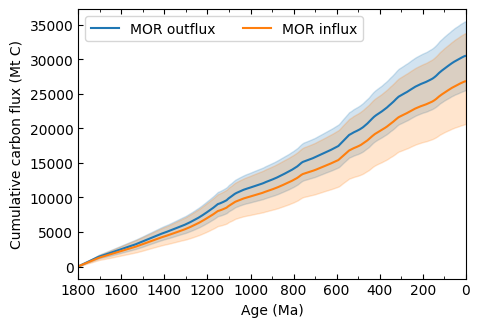

In [11]:
fig = plt.figure(figsize=(5,3.5))
ax = fig.add_subplot(111, xlabel='Age (Ma)', ylabel='Cumulative carbon flux (Mt C)', xlim=[max_time,min_time])

time_window = 10 #myr

ax.fill_between(reconstruction_times,
                sn.median_filter(np.cumsum(MOR_outflux[0,::-1])[::-1], size=time_window),
                sn.median_filter(np.cumsum(MOR_outflux[2,::-1])[::-1], size=time_window),
                color='C0', alpha=0.2)
ax.plot(reconstruction_times, sn.median_filter(np.cumsum(MOR_outflux[1,::-1])[::-1], size=time_window), c="C0", label='MOR outflux')


ax.fill_between(reconstruction_times,
                sn.median_filter(np.cumsum(MOR_influx[0,::-1])[::-1], size=time_window),
                sn.median_filter(np.cumsum(MOR_influx[2,::-1])[::-1], size=time_window),
                color='C1', alpha=0.2)
ax.plot(reconstruction_times, sn.median_filter(np.cumsum(MOR_influx[1,::-1])[::-1], size=time_window), c="C1", label='MOR influx')

ax.legend(ncol=2, loc='upper left')
ax.xaxis.set_minor_locator(MultipleLocator(100))
ax.tick_params(axis="both", direction="in", which="both", right=False, top=True)

fig.savefig(output_directory+"/figures/cumulative_ridge_outflux.svg", bbox_inches='tight', dpi=300)
fig.savefig(output_directory+"/figures/cumulative_ridge_outflux.pdf", bbox_inches='tight', dpi=300)
fig.savefig(output_directory+"/figures/cumulative_ridge_outflux.png", bbox_inches='tight', dpi=300)


# save to pandas dataframe
data_out = np.column_stack((
    sn.median_filter(MOR_outflux[0], size=time_window),
    sn.median_filter(MOR_outflux[1], size=time_window),
    sn.median_filter(MOR_outflux[2], size=time_window),
    sn.median_filter(MOR_influx[0], size=time_window),
    sn.median_filter(MOR_influx[1], size=time_window),
    sn.median_filter(MOR_influx[2], size=time_window),
    sn.median_filter(np.cumsum(MOR_outflux[0]), size=time_window),
    sn.median_filter(np.cumsum(MOR_outflux[1]), size=time_window),
    sn.median_filter(np.cumsum(MOR_outflux[2]), size=time_window),
    sn.median_filter(np.cumsum(MOR_influx[0]), size=time_window),
    sn.median_filter(np.cumsum(MOR_influx[1]), size=time_window),
    sn.median_filter(np.cumsum(MOR_influx[2]), size=time_window)
))

headers = ['outflux', 'influx', 'cumulative_outflux', 'cumulative_influx']
quantiles = ['min', 'mean', 'max']
index = pd.MultiIndex.from_product([headers, quantiles])
ridge_outflux_pd = pd.DataFrame(list(data_out), columns = index, index=reconstruction_times) 
ridge_outflux_pd.to_csv(output_directory+"/csv/03_ridge_outflux.csv", index_label='age')

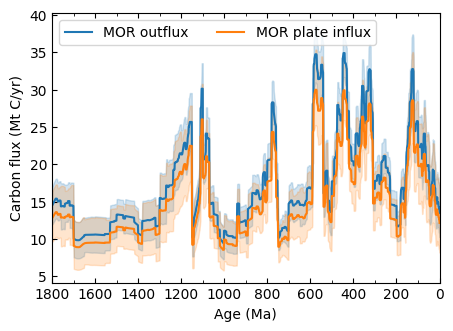

In [12]:
fig = plt.figure(figsize=(5,3.5))
ax = fig.add_subplot(111, xlabel='Age (Ma)', ylabel='Carbon flux (Mt C/yr)', xlim=[max_time,min_time])

time_window = 10 #Myr

ax.fill_between(reconstruction_times,
                sn.median_filter(MOR_outflux[0], size=time_window),
                sn.median_filter(MOR_outflux[2], size=time_window),
                color='C0', alpha=0.2)
ax.plot(reconstruction_times, sn.median_filter(MOR_outflux[1], size=time_window), c='C0', label='MOR outflux')

ax.fill_between(reconstruction_times,
                sn.median_filter(MOR_influx[0], size=time_window),
                sn.median_filter(MOR_influx[2], size=time_window),
                color='C1', alpha=0.2)
ax.plot(reconstruction_times, sn.median_filter(MOR_influx[1], size=time_window), c='C1', label='MOR plate influx')
ax.xaxis.set_minor_locator(MultipleLocator(100))
ax.tick_params(axis="both", direction="in", which="both", right=False, top=True)

ax.legend(ncol=2, loc='upper left')
fig.savefig(output_directory+"/figures/ridge_outflux.pdf", bbox_inches='tight', dpi=300)
fig.savefig(output_directory+"/figures/ridge_outflux.svg", bbox_inches='tight', dpi=300)
fig.savefig(output_directory+"/figures/ridge_outflux.png", bbox_inches='tight', dpi=300)

## Carbon degassing in the mantle

### Interpolating CO$_{2}$ wt.% lost at depth 

---

Author: Christopher M. Gonzalez

Contact: christophmgonzalez@gmail.com

Phone: +610426940721

---

Purpose: Calculate the amount of CO$_{2}$ lost at depth using a _look-up_ table approach. Uses only standard libraries of numpy and scipy.interpolate.

Reads in gridded `.dat` information as a function of P(ressure), T(emperature), and CO$_2$/H$_2$O wt.% into an array CO2Array_TPZ. Returns the interpolated CO2 wt.% at depth


Relevant equations:

$$\phi_{T,P} = A_{\mathrm{Ma}} \times V_{\mathrm{slab}} \times \sin(\delta) $$

Where $\phi$ is the thermal parameter, $A$ - Age of the slab in years, $V_{\mathrm{slab}}$ - Velocity of the slab in km yr$^{-1}$, $\delta$ - slab dip in degrees.

Slab top temperatures are derived from Van Keken et. al (2011) from section 3.1 at the following reference:

> Van Keken, P. E., Hacker, B. R., Syracuse, E. M., & Abers, G. A. (2011). Subduction factory: 4. Depth-dependent flux of H2O from subducting slabs worldwide. Journal of Geophysical Research: Solid Earth, 116(1). https://doi.org/10.1029/2010JB007922

Their logic is that at depth, the temperature of the slab can be reduced to a log-linear Temperature relationship as a function of the thermal parameter ($\phi$) for the following lithologies: Sediments, Volcanics, and the temperature at the Oceanic crustal moho (i.e., the base of the intrusives ~7km depth). <br> Since the an approximation for sub-arc depths (ranges from ~70 - 200 km) with the median ~100-120 km depth from continental-onceanic and intraoceanic arc ranges 90-160 without a clear peak in its distribution (e.g., Schmidt and Poli 2013). 

Total CO2 loss can be calculated as follows: 

 CO$_{2}$$_{\mathrm{loss}}$ = CO$_{2}$$_{\mathrm{final}}$ - CO$_{2}$$_{\mathrm{initial}}$

Where the integrated loss of CO2 can be calculated as a function of each lithology.

N.B. the following assumptions:
1. CO2 loss is only calculated as a point value difference and not as a path function
2. This is an extremely conservative value, meaning CO2 loss is due strictly to thermal breakdown and not due to infiltration of water from subjacent lithologies. 
3. All CO2 loss in this physically implausible model suggest it is lost in batch process at this depth.
4. Relies on the validity of the thermal parameter and applying some form of uniformitarianism, it is also applicable back in time. 


P, T, [CO2 | H2O] wt.% data is calculated on a regular grid of 313 x 313 nodes using the thermodynamic modelling software: Perple_X (Connolly, 2009; http://www.perplex.ethz.ch/).

Perple_X version information: `Perple_X version 6.9.0, source updated October 11, 2020`

```
Grid parameters:
T_{0}: 573 Kelvin
P_{0}: 500 bars
Pressure resolution: 286.85897435897436 bars
Temperature resolution: 3.5256410256410255 Kelvins
```

We use __30 km__ as the thickness of the Serpentinization layer from Faccenda, 2014.


References: 
---

> 1. Connolly, J. A. D. (2009). The geodynamic equation of state: What and how. Geochemistry, Geophysics, Geosystems, 10(10). https://doi.org/10.1029/2009GC002540
> 2. Schmidt, M. W., & Poli, S. (2014). Devolatilization During Subduction. In H. D. Turekian & K. HollandKarl (Eds.), Treatise on Geochemistry (2nd ed., Vol. 4, pp. 669–701). Elsevier. https://doi.org/10.1016/B978-0-08-095975-7.00321-1
> 3. Faccenda, M. (2014). Water in the slab: A trilogy. Tectonophysics, 614, 1–30. https://doi.org/10.1016/j.tecto.2013.12.020



In [13]:
perplex_filedir = "./utils/loss_of_subducting_CO2_with_depth/Lookuptables/"

lookup_tables = np.empty((4, 313, 313))

for i, table in enumerate(['Sediments/GLOSS_CO2.dat',
                           'Metabasalts/StaudigelVolcanics_CO2.dat',
                           'Intrusives/Intrusives_CO2.dat',
                           'Sublithospheric_Oceanic_mantle/LOSIMAG_CO2.dat']):
    CO2Array_TPZ = np.genfromtxt(perplex_filedir + table, skip_header=12, autostrip=True)
    lookup_tables[i] = CO2Array_TPZ[:,2].reshape(313,313)
    
T_coords = CO2Array_TPZ[:,0].reshape(313,313)[0,:]
P_coords = CO2Array_TPZ[:,1].reshape(313,313)[:,0]

lookup_interp = gplately.grids.RegularGridInterpolator((P_coords, T_coords), lookup_tables[i],
                                        method='nearest', bounds_error=False, fill_value=None)

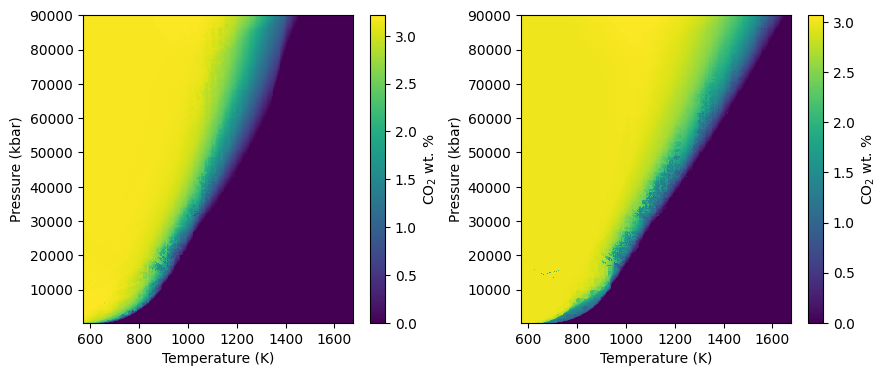

In [14]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))
plt.subplots_adjust(wspace=0.3)

carbon_outflux_sources = ["Sediments", "Volcanics", "Intrusives", "Lithospheric mantle"]


for i, ax in enumerate([ax1,ax2]):
#     ax.set_title(carbon_outflux_sources[i])
    ax.set_xlabel('Temperature (K)')
    ax.set_ylabel('Pressure (kbar)')
    im = ax.pcolormesh(T_coords, P_coords, lookup_tables[i], shading='auto', rasterized=True)
    fig.colorbar(im, ax=ax, label='CO$_2$ wt. %')
    
fig.savefig(output_directory+"/figures/perplex_CO2_wt_percent.pdf", bbox_inches='tight', dpi=300)
fig.savefig(output_directory+"/figures/perplex_CO2_wt_percent.svg", bbox_inches='tight', dpi=300)
fig.savefig(output_directory+"/figures/perplex_CO2_wt_percent.png", bbox_inches='tight', dpi=300)

In [15]:
verbose = False

def calcPhi(slabAge, slabVelocity, slabDip):
    """
    Take in values of slab dip and return phi, the thermal parameter.
    
    Parameters
    ----------
    slabAge : age of slab (Ma)
    slabVelocity : convergence rate of slab (cm/yr)
    slabDip : dip angle of slab from trench hinge (degrees)
    
    Returns
    -------
    Phi : the thermal parameter
    """
    # phiTP = A(ge) * V(elocity) * sin(\delta)
    # Age: Myrs -> yrs
    slabAge = slabAge * 1e+6
    # Slab velocity: cm/year -> km/yr
    slabVelocity = slabVelocity*1e-5
    # Slab dip calculation, note numpy does things in radians, need to convert to degrees
    slabDip = np.sin(np.deg2rad(slabDip))
    
    if verbose:
        print("Slab age: {} years \n Slab Velocity: {} km yr \n sin(d): {} \n Product: {}".format(
            slabAge, slabVelocity, slabDip, slabAge*slabVelocity*slabDip))

    # Return the product phiTP
    return slabAge*slabVelocity*slabDip

def calcSlabTemperatures(Phi):
    """
    Calculate temperature, equations from Phi
    
    Returns
    -------
    T_sediments : temperature (Celsius) at sediments interface
    T_volcanics : temperature (Celsius) at volcanics interface
    T_Moho      : temperature (Celsius) at the Moho
    """
    T_Sediments = 1331. - 58.6*np.log(Phi)
    T_Volcanics = 1303. - 60.23*np.log(Phi)
    T_Moho      = 1622. - 132.5*np.log(Phi)
    
    if verbose:
        print("TSed: {} \n TVolc: {} \n TMoho: {}".format(T_Sediments, T_Volcanics, T_Moho))
    
    return T_Sediments, T_Volcanics, T_Moho

def sample_lookup_table(P, T, lithology):
    """
    Interpolation function. Takes in the approximated Depth to pressure conversion and
    calculated temperature from the slab tops using Van Keken (2011) and the thermal parameter.
    
                                                 0   1    2
    Read in CO2 data generated from Perple_X.  [ T,  P,  CO2]
    
    Parameters
    ----------
    P : pressure in bars
    T : temperature in Kelvin
    lithology : lithology ID
        0 = sediments
        1 = metabasalts
        2 = intrusives
        3 = sublithospheric oceanic mantle
        
    Returns
    -------
    CO2 : CO2 wt. % for a given pressure and temperature from the specified lookup table lithology
    """
    if lithology not in [0,1,2,3]:
        raise ValueError("lithology must be an integer in the range [0,3]")

    lookup_interp.values = lookup_tables[lithology]
    return lookup_interp((P,T))

For now, the Merdith et al. (2021) model has no sediment thickness grids before 250 Ma. Assume that there are no sediments before that time.

Use 0.25d sediment thickness grids.

In [16]:
# Input sediment thickness grids for 250-0
sediments_filename = grid_directory+"TotalSediment/sed_thick_0.1d_{:.1f}.nc"

# Before 250Ma, assume no sediments. For this we use the continent mask at that time.
continental_mask_filename = grid_directory+"ContinentalMasks/continent_mask_{:.1f}.nc"

# Path to the output mean crustal carbon grids from the /utils/Min-Mean-Max-Crustal-Carbon.ipynb 
# notebook or otherwise
crust_filename = grid_directory+"CrustalCarbon/mean/{}/upper_crustal_CO2_mean_{}.nc"


def reconstruct_slab_storage(
    time, model, tessellation_threshold_radians
):

    agegrid_filename, spreadrate_filename = defineGridFiles()

    # Initialise SlabDipper object, allocate it a spreading rate grid and an age grid
    dipper = SlabDipper()
    dipper._model = model
    dipper.set_age_grid_filename(agegrid_filename)
    dipper.set_spreading_rate_grid_filename(spreadrate_filename)
    
    subduction_df = dipper.tessellate_slab_dip(time, tessellation_threshold_radians)

    # SUBDUCTION DATA -----------------------------------------------------------------
    subduction_lon     = subduction_df.lon
    subduction_lat     = subduction_df.lat
    subduction_length  = subduction_df.length
    subduction_convergence = subduction_df.vel
    
    # sample carbon grid at subduction zones
    age_interp = subduction_df.slab_age
    thickness = subduction_df.slab_thickness

    slab_dip = subduction_df.slab_dip
    # ----------------------------------------------------------------------------------

    sedtime = time
    
    sediment_thickness_grid = gplately.grids.read_netcdf_grid(sediments_filename.format(sedtime), resample=(0.2,0.2))
    sediment_thickness_filled = gplately.grids.fill_raster(sediment_thickness_grid)
    sediment_thickness_interp = gplately.grids.sample_grid(
        subduction_lon, subduction_lat, sediment_thickness_filled)    

    # crust_wtpercent_grid = read_netcdf_grid(crust_filename.format(time), resample=(0.2,0.2))
    # crust_wtpercent_filled = fill_ndimage(crust_wtpercent_grid)
    # crust_wtpercent_interp = sample_grid(subduction_lon, subduction_lat, crust_wtpercent_filled)

    Phi = calcPhi(age_interp, subduction_convergence*100, slab_dip)
    T_sediments, T_volcanics, T_moho = calcSlabTemperatures(Phi+1e-12)

    # Calculations are for a constant pressure (4.3750 GPa) at 125 km
    # Assumed 9.81 m/s (gravity) and density of 3500 kg/m3
    P = np.full_like(T_sediments, 125e3*9.81*3500e3*1e-8)

    # convert CO2 wt % to kg/m3 (multiply by constant density)
    CO2_sediments = sample_lookup_table(P, T_sediments+273.14,    lithology=0) * 3500.0/100 # density
    CO2_volcanics = sample_lookup_table(P, T_volcanics+273.14,    lithology=1) * 3500.0/100 # density
    CO2_intrusive = sample_lookup_table(P, T_moho+273.14,         lithology=3) * 3500.0/100 # density
    CO2_mantlelit = sample_lookup_table(P, T_moho+273.14,         lithology=3) * 3500.0/100
    
    # correct CO2 volcanics by total amount that is possible to extract
    # CO2_volcanics = np.minimum(CO2_volcanics, crust_wtpercent_interp * 3500.0/100)

    # integrate by volume (now CO2)
    CO2_sediments *= sediment_thickness_interp * subduction_length * subduction_convergence*1e6 # 100m thickness
    CO2_volcanics *= 450.0 * subduction_length * subduction_convergence*1e6 # 450m thickness
    CO2_intrusive *= 30e3*0.4 * subduction_length * subduction_convergence*1e6 # 7km thickness
    CO2_mantlelit *= (thickness-sediment_thickness_interp-7e3)* subduction_length * subduction_convergence*1e6

    # convert t CO2 to Mt carbon from ratio of molecular weight
    carbon_sediments = CO2_sediments * 12.0107/44.0095 * 1e-9
    carbon_volcanics = CO2_volcanics * 12.0107/44.0095 * 1e-9
    carbon_intrusive = CO2_intrusive * 12.0107/44.0095 * 1e-9
    carbon_mantlelit = CO2_mantlelit * 12.0107/44.0095 * 1e-9
    
#     print("T", np.median(T_sediments), np.median(T_volcanics), np.median(T_moho))
#     print("Phi", np.median(Phi), "age", np.median(age_interp), 'vel', np.median(subduction_convergence*100), 'dip', np.median(slab_dip))

    #def interquartiles(field):
    #    return np.percentile(field, 25), np.percentile(field, 50), np.percentile(field, 75)
    #
    #output = []
    #output.extend( interquartiles(Phi) )
    #output.extend( interquartiles(subduction_convergence) )
    #output.extend( interquartiles(slab_dip) )
    #output.extend( interquartiles(T_sediments) )
    #output.extend( interquartiles(T_volcanics) )
    #output.extend( interquartiles(T_moho) )
    
    # Slab storage
    sediments_slab_storage = carbon_sediments.sum()*1e-6
    volcanics_slab_storage = carbon_intrusive.sum()*1e-6
    intrusive_slab_storage = carbon_volcanics.sum()*1e-6
    mantlelit_slab_storage = carbon_mantlelit.sum()*1e-6
    

    return sediments_slab_storage, volcanics_slab_storage, intrusive_slab_storage, mantlelit_slab_storage


In [17]:
reconstruct_slab_storage(1799, model, tessellation_threshold_radians)

/Users/lila0720/micromamba/envs/env_gplately/lib/python3.11/site-packages/gplately/grids.py:820: RuntimeWarning: Invalid values encountered in lat; clipping to [-90, 90]


(5.612339368107996, 2.3184738502530626, 24.236490735158704, 16.633458529386655)

In [18]:
%env PYTHONWARNINGS=ignore::RuntimeWarning
        
parallel_slab_storage = Parallel(n_jobs=-3, verbose=1) \
(delayed(reconstruct_slab_storage) \
 (time, model,
  tessellation_threshold_radians) for time in reconstruction_times)

env: PYTHONWARNINGS=ignore::RuntimeWarning


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
/Users/lila0720/micromamba/envs/env_gplately/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-3)]: Done 184 tasks      | elapsed: 16.4min
[Parallel(n_jobs=-3)]: Done 434 tasks      | elapsed: 37.7min
[Parallel(n_jobs=-3)]: Done 784 tasks      | elapsed: 67.4min
[Parallel(n_jobs=-3)]: Done 1234 tasks      | elapsed: 105.7min
[Parallel(n_jobs=-3)]: Done 1784 tasks      | elapsed: 152.2min
[Parallel(n_jobs=-3)]: Done 1800 out of 1800 | elapsed: 153.6min finished


In [19]:
slab_storage = np.zeros((4, reconstruction_times.size))
for i, mode in enumerate(zip(*parallel_slab_storage)):
    slab_storage[i,:] = np.array(mode)

How to rationalise the carbon going into the mantle vs. carbon that is liberated from the slab. Surely you can't liberate more than is already in the slab, so we __truncate__ where that occurs.

### Read subducted carbon from notebook 2
These values will be smoothed using the `time_window` in Notebook 2, set to 10 Myr.

In [20]:
subducted_carbon_df = pd.read_csv(
    "./Outputs/Notebook02/csv/02_subducted_carbon.csv", 
    index_col=0, header=[0,1]
)
subducted_carbon_df = subducted_carbon_df.reindex(index=reconstruction_times)

sediment_influx     = subducted_carbon_df.loc[:, (['sediments'], ['min', 'mean', 'max'])].to_numpy()
serpentinite_influx = subducted_carbon_df.loc[:, (['serpentinite'], ['min', 'mean', 'max'])].to_numpy()
crust_influx = subducted_carbon_df.loc[:, (['crust'], ['min', 'mean', 'max'])].to_numpy()
lithosphere_influx = subducted_carbon_df.loc[:, (['lithosphere'], ['min', 'mean', 'max'])].to_numpy()

In [21]:
carbon_components = ["Sediment", "Serpentinite", "Crust", "Lithosphere"]
quantities = ["min", "mean", "max"]

time_window = 10

# have to expand to include min / mean / max quantities
slab_storage_full = np.zeros((4,1800,3))
slab_outflux = np.zeros((4,1800,3))

for i, influx in enumerate([sediment_influx, serpentinite_influx, crust_influx, lithosphere_influx]):
#     mantle_outflux_full[i,:,:] = np.minimum(mantle_outflux[i].reshape(-1,1), influx)
    clipped_slab_storage = np.clip(slab_storage[i], 0., None)
    smoothed_slab_storage = sn.median_filter(clipped_slab_storage, time_window)
    
    slab_storage_full[i,:,:] = np.minimum(smoothed_slab_storage.reshape(-1,1), influx)
    
    if i == 0:
        rel_influx_min = slab_storage_full[i,:,1] - influx[:,0]/influx[:,1]
        rel_influx_max = slab_storage_full[i,:,1] + influx[:,1]/influx[:,2]
        slab_storage_full[i,:,0] = np.clip(rel_influx_min, 0, 1e99)
        slab_storage_full[i,:,2] = np.clip(rel_influx_max, 0, 1e99)
        slab_storage_full[i,:,:][np.isnan(slab_storage_full[i,:,:])] = 0

    slab_outflux[i,:,:] = influx - smoothed_slab_storage.reshape(-1,1)
    
# override serpentinite layer carbon
slab_outflux[1,:] = 1e99
slab_outflux[1,:]= -1e99

slab_outflux = np.clip(slab_outflux, 0, 1e99)

/var/folders/ry/3sftjhts50x0vr1cmqhbw1z40000gp/T/ipykernel_6446/1815509556.py:18: RuntimeWarning: invalid value encountered in divide
/var/folders/ry/3sftjhts50x0vr1cmqhbw1z40000gp/T/ipykernel_6446/1815509556.py:19: RuntimeWarning: invalid value encountered in divide


## Plots of carbon outflux

Note the array `slab_outflux` was median-smoothed in the cell it was defined.

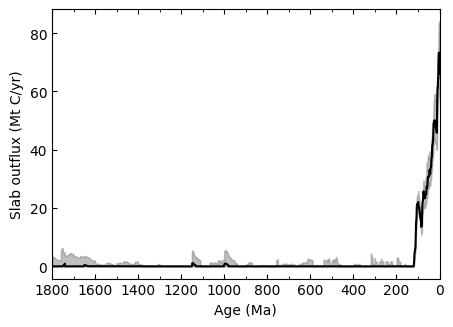

In [22]:
fig = plt.figure(figsize=(5,3.5))
ax = fig.add_subplot(111, xlabel='Age (Ma)', ylabel='Slab outflux (Mt C/yr)', xlim=[max_time,0])

ax.fill_between(reconstruction_times,
                slab_outflux.sum(axis=0)[:,0],
                slab_outflux.sum(axis=0)[:,2],
                color='0.5', alpha=0.5, )

ax.plot(reconstruction_times, slab_outflux.sum(axis=0)[:,1], c="k", label='Total')
ax.xaxis.set_minor_locator(MultipleLocator(100))
ax.tick_params(axis="both", direction="in", which="both", right=False, top=True)
    
fig.savefig(output_directory+"/figures/slab_outflux.pdf", bbox_inches='tight', dpi=300)
fig.savefig(output_directory+"/figures/slab_outflux.svg", bbox_inches='tight', dpi=300)
fig.savefig(output_directory+"/figures/slab_outflux.png", bbox_inches='tight', dpi=300)


# save xy data

data_out = np.column_stack(
    (
        slab_outflux[0,:,:],
        slab_outflux[1,:,:],
        slab_outflux[2,:,:],
        slab_outflux[3,:,:],
        slab_outflux.sum(axis=0)[:,0],
        slab_outflux.sum(axis=0)[:,1],
        slab_outflux.sum(axis=0)[:,2]
    )
)

headers = ['outflux_sediments', 'outflux_intrusive', 'outflux_volcanics', 
           'outflux_mantlelit', 'outflux_total']
quantiles = ['min', 'mean', 'max']

index = pd.MultiIndex.from_product([headers, quantiles])
slab_outflux_df = pd.DataFrame(list(data_out), columns = index, index=reconstruction_times) 
slab_outflux_df.to_csv(output_directory+"/csv/03_slab_outflux.csv", index_label='age')

In [23]:
diamond_age, diamond_lon, diamond_lat = np.loadtxt(
    './utils/diamonds_age_lon_lat_country_Guiliani_2019_250-0_North_America.txt', usecols=(0,1,2), unpack=True)

mask_diamonds = diamond_lon < 0
diamond_age = diamond_age[mask_diamonds]
diamond_lon = diamond_lon[mask_diamonds]
diamond_lat = diamond_lat[mask_diamonds]

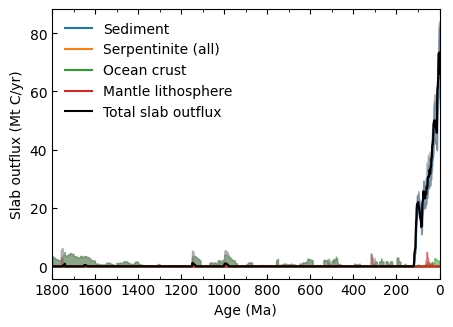

In [24]:
carbon_components_extended = ["Sediment", "Serpentinite (all)", "Ocean crust", 
                              "Mantle lithosphere"]
colours = ['C0', 'C1', 'C2', 'C3']

fig = plt.figure(figsize=(5,3.5))
ax = fig.add_subplot(111, xlabel='Age (Ma)', ylabel='Slab outflux (Mt C/yr)', xlim=[max_time,0]) #, ylim=[0,80])

for i, source in enumerate(carbon_components_extended):
    ax.fill_between(reconstruction_times,
                    slab_outflux[i,:,0],
                    slab_outflux[i,:,2],
                    color='C{}'.format(i), alpha=0.5)
    ax.plot(reconstruction_times, slab_outflux[i,:,1], c='C{}'.format(i), label=source)
    ax.xaxis.set_minor_locator(MultipleLocator(100))
    ax.tick_params(axis="both", direction="in", which="both", right=False, top=True)
    
ax.fill_between(reconstruction_times,
                slab_outflux.sum(axis=0)[:,0],
                slab_outflux.sum(axis=0)[:,2],
                color='0.5', alpha=0.5, )

ax.plot(reconstruction_times, slab_outflux.sum(axis=0)[:,1], c="k", label='Total slab outflux')
    
ax.legend(frameon=False, loc='upper left')

fig.savefig(output_directory+"/figures/slab_outflux_comparison_sameaxes.pdf", bbox_inches='tight', dpi=300)
fig.savefig(output_directory+"/figures/slab_outflux_comparison_sameaxes.svg", bbox_inches='tight', dpi=300)
fig.savefig(output_directory+"/figures/slab_outflux_comparison_sameaxes.png", bbox_inches='tight', dpi=300)

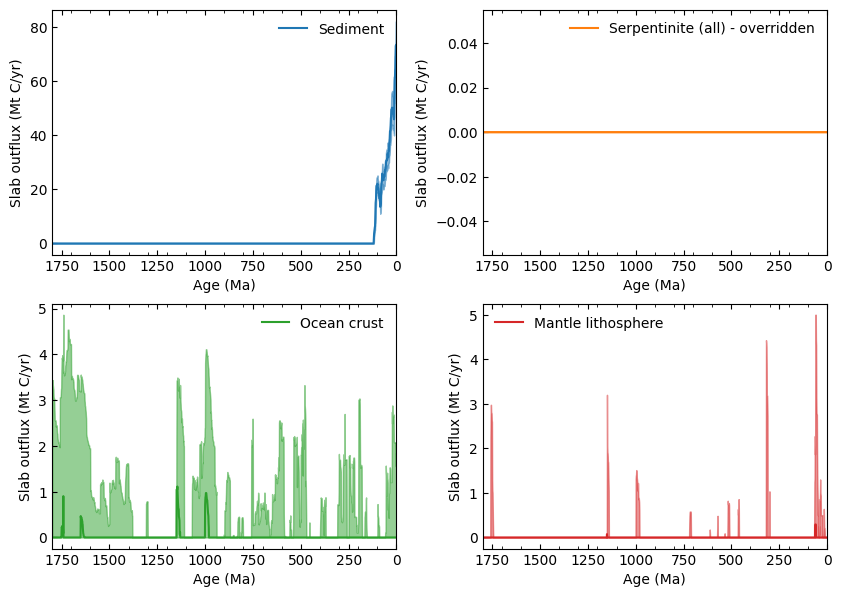

In [25]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(10,7))

time_window = 10 #Myr

for i, ax in enumerate([ax1,ax2,ax3,ax4]):
    
    source = carbon_components_extended[i]
    
    ax.fill_between(reconstruction_times,
                    slab_outflux[i,:,0],
                    slab_outflux[i,:,2],
                    color='C{}'.format(i), alpha=0.5)
    
    if i == 1:
        label = "Serpentinite (all) - overridden"
    else:
        label = source
    ax.plot(reconstruction_times, slab_outflux[i,:,1], c='C{}'.format(i), label=label)
    
    ax.set_xlim(max_time,0)
    ax.set_xlabel('Age (Ma)')
    ax.set_ylabel('Slab outflux (Mt C/yr)')
    ax.legend(frameon=False)
    ax.xaxis.set_minor_locator(MultipleLocator(100))
    ax.tick_params(axis="both", direction="in", which="both", right=False, top=True)
    
plt.subplots_adjust(wspace=0.25)


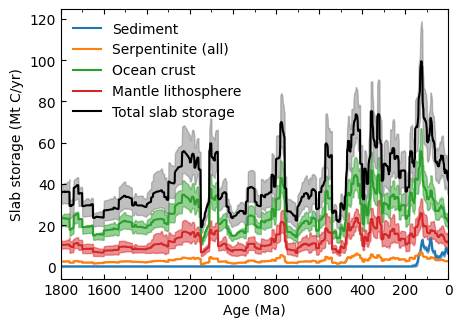

In [26]:
fig = plt.figure(figsize=(5,3.5))
ax = fig.add_subplot(111, xlabel='Age (Ma)', ylabel='Slab storage (Mt C/yr)', xlim=[max_time,0])

for i, source in enumerate(carbon_components_extended):
    

    ax.fill_between(reconstruction_times,
                    slab_storage_full[i,:,0],
                    slab_storage_full[i,:,2],
                    color='C{}'.format(i), alpha=0.5)
    ax.plot(reconstruction_times, slab_storage_full[i,:,1], c='C{}'.format(i), label=source)

ax.fill_between(reconstruction_times,
                slab_storage_full.sum(axis=0)[:,0],
                slab_storage_full.sum(axis=0)[:,2],
                color='0.5', alpha=0.5, )

ax.plot(reconstruction_times, 
        slab_storage_full.sum(axis=0)[:,1], c="k", label='Total slab storage'
)
    
ax.legend(frameon=False, loc='upper left')
ax.xaxis.set_minor_locator(MultipleLocator(100))
ax.tick_params(axis="both", direction="in", which="both", right=False, top=True)
    
fig.savefig(output_directory+"/figures/slab_storage_comparison_sameaxes.pdf", bbox_inches='tight', dpi=300)
fig.savefig(output_directory+"/figures/slab_storage_comparison_sameaxes.svg", bbox_inches='tight', dpi=300)
fig.savefig(output_directory+"/figures/slab_storage_comparison_sameaxes.png", bbox_inches='tight', dpi=300)

In [27]:
# save xy data
time_window = 10 #Myr

data_out = np.column_stack(
    (
        slab_storage_full[0,:,:],
        slab_storage_full[1,:,:],
        slab_storage_full[2,:,:],
        slab_storage_full[3,:,:],
        slab_storage_full.sum(axis=0)[:,0],
        slab_storage_full.sum(axis=0)[:,1],
        slab_storage_full.sum(axis=0)[:,2]
    )
)

headers = ['stored_sediments', 'stored_serpentinite', 'stored_crust', 'stored_mantlelit', 'stored_total']
quantiles = ['min', 'mean', 'max']
index = pd.MultiIndex.from_product([headers, quantiles])
slab_storage_df = pd.DataFrame(list(data_out), columns = index, index=reconstruction_times) 
slab_storage_df.to_csv(output_directory+"/csv/03_slab_storage.csv", index_label='age')